In [1]:
import torch
import numpy as np
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
# from torchvision.utils.data.sampler import 
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [2]:
dataset = MNIST(root='data/',download=True,transform=ToTensor())

In [3]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

Label: 7


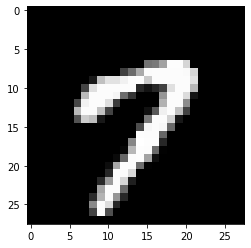

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
img ,  lab = dataset[15]
plt.imshow(img[0],cmap='gray')
print('Label:',lab)

In [5]:
# Spliting Indices into validation sets
def split_indices(n,val_pct):
    # detremine size of validation set
    n_val = int(n*val_pct)
    # creating random permutations from 0 to n-1
    indx = np.random.permutation(n)
    # pick first n_val indices for validation set
    return indx[n_val:],indx[:n_val]

In [6]:
train_indices, val_indices = split_indices(len(dataset),val_pct=0.2)
print('Train indices length:',len(train_indices))
print('Validation indices length:',len(val_indices))

Train indices length: 48000
Validation indices length: 12000


In [7]:
train_indices[:20]

array([27396, 46782, 20023, 44491, 21707, 16712,  5655, 20987, 40719,
       45276, 37441, 48701, 21502, 30854, 16487, 31332,  4608,  2717,
       44474, 44263])

In [8]:
val_indices[:20]

array([11942, 33735, 38101, 17405, 33468, 42590, 12838, 28790, 28640,
       47412, 26270, 31101, 50718, 23365, 18368, 57241, 43284, 31300,
       40601, 10358])

In [9]:
batch_size = 100

# traning sampler data loder
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,batch_size,sampler=train_sampler)

# validation sampler data loder
valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,batch_size,sampler=valid_sampler)

In [10]:
# model
import torch.nn.functional as F
import torch.nn as nn

In [11]:
class MnistModel(nn.Module):
    '''feed forward neural network with 2 hidden layers'''
    def __init__(self,input_size,hidden_size1,hidden_size2,output_size):
        super().__init__()
        # hidden layer 1
        self.linear1 = nn.Linear(input_size,hidden_size1)
        #  hidden layer 2
        self.linear2 = nn.Linear(hidden_size1,hidden_size2)
        # output layer
        self.linear3 = nn.Linear(hidden_size2,output_size)
        
    def forward(self,xb):
        # flatten image tensor
        xb = xb.view(xb.size(0),-1)
        # getting intermediate output using hidden layer 1
        out = self.linear1(xb)
        # Applying Activation Function layer 1
        out = F.relu(out)
        # getting second output using hidden layer 2
        out = self.linear2(out)
        # Applying Activation Function
        out = F.relu(out)
        # getting output by third layer
        out = self.linear3(out)
        return out
        

In [12]:
input_size = 784
num_classes = 10

model = MnistModel(input_size,hidden_size1=64,hidden_size2=32,output_size=num_classes)

In [13]:
for t in model.parameters():
    print(t.shape)

torch.Size([64, 784])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [14]:
def get_default_device():
    '''if cuda found then use GPU else CPU'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [15]:
device = get_default_device()
device

device(type='cpu')

In [16]:
def to_device(data,device):
    '''if cuda available then move tensors in GPU memory'''
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [17]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    
    def __iter__(self):
        """Yield a batch of data after moving it to devices"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    

In [18]:
train_dl = DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl,device)

In [19]:
for xb,yb in valid_dl:
    print('xb.device :',xb.device)
    print('yb :',yb)
    break

xb.device : cpu
yb : tensor([2, 9, 4, 3, 0, 6, 6, 3, 5, 6, 2, 4, 7, 2, 2, 4, 3, 0, 1, 7, 7, 9, 7, 0,
        9, 1, 2, 6, 1, 8, 2, 2, 4, 4, 9, 4, 4, 9, 1, 6, 4, 9, 3, 1, 2, 8, 4, 5,
        7, 2, 2, 8, 0, 7, 5, 5, 0, 9, 6, 9, 0, 6, 7, 9, 2, 4, 7, 5, 2, 4, 4, 8,
        4, 7, 2, 3, 6, 7, 5, 9, 1, 2, 2, 9, 8, 1, 3, 9, 5, 3, 9, 4, 9, 2, 8, 3,
        0, 1, 6, 1])


In [20]:
for xb, yb in valid_dl:
    print('xb.device',xb.device)
    print('yb:',yb)
    break

xb.device cpu
yb: tensor([6, 0, 7, 3, 6, 9, 8, 2, 7, 2, 3, 0, 7, 6, 7, 6, 8, 8, 2, 1, 8, 2, 8, 1,
        2, 5, 3, 6, 6, 1, 7, 2, 7, 5, 7, 2, 0, 4, 9, 1, 3, 7, 1, 7, 1, 8, 5, 4,
        7, 2, 4, 2, 5, 0, 6, 8, 7, 3, 8, 1, 2, 6, 7, 6, 8, 2, 7, 9, 4, 2, 5, 2,
        8, 0, 6, 1, 4, 1, 3, 5, 3, 6, 3, 5, 4, 1, 1, 2, 8, 6, 7, 3, 2, 5, 3, 3,
        5, 0, 8, 7])


In [21]:
# train model

In [22]:
def loss_batch(model,loss_func,xb,yb,opt=None,metric=None):
    preds = model(xb)
    loss = loss_func(preds,yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    metric_result = None
    if metric is not None:
        metric_result = metric(preds,yb)
    
    return loss.item(), len(xb),metric_result

In [23]:
def evaluate(model,loss_fn,valid_dl,metric=None):
    with torch.no_grad():
        results = [loss_batch(model,loss_fn,xb,yb,metric=metric)for xb,yb in valid_dl]
        
        losses, nums, metrics = zip(*results)
        
        total = np.sum(nums)
        
        avg_loss = np.sum(np.multiply(losses,nums))/total
        
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics,nums))/total
        
        return avg_loss,total,avg_metric

In [24]:
def fit(epochs,model,lr,loss_fn,train_dl,valid_dl,metric=None,opt_fn=None):
    losses , metrics = [] , []
    
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(),lr=lr)
    
    for epoch in range(epochs):
        
        for xb,yb in train_dl:
            loss_batch(model,loss_fn,xb,yb,opt)
            
        result = evaluate(model,loss_fn,valid_dl,metric)
        val_loss,total,val_metric = result
        
        losses.append(val_loss)
        metrics.append(val_metric)
        
        if metric is None:
            print('Epoch [{}/{}] , Loss : {:.4f}'.format(epoch+1,epochs,val_loss))
        else:
            print('Epoch [{}/{}] , Loss : {:.4f} {} : {:.4f}'.format(epoch+1,epochs,val_loss,metric.__name__,val_metric))
            
    return losses,metrics
        
        

In [25]:
def accuracy(outputs,labels):
    _,preds = torch.max(outputs,dim=1)
    return torch.sum(preds==labels).item()/len(preds)

In [26]:
# model on CPU
model = MnistModel(input_size,hidden_size1=64,hidden_size2=49,output_size=num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=49, bias=True)
  (linear3): Linear(in_features=49, out_features=10, bias=True)
)

In [27]:
val_loss,total,val_acc = evaluate(model,F.cross_entropy,valid_dl,metric=accuracy)


In [28]:
print('Loss : {} , Accuracy : {}'.format(val_loss,val_acc))

Loss : 2.3095740815003714 , Accuracy : 0.07883333333333334


In [29]:
losses1,metric1 = fit(10,model,0.1,F.cross_entropy,train_dl,valid_dl,accuracy)

Epoch [1/10] , Loss : 0.3399 accuracy : 0.8986
Epoch [2/10] , Loss : 0.2557 accuracy : 0.9249
Epoch [3/10] , Loss : 0.2130 accuracy : 0.9396
Epoch [4/10] , Loss : 0.1735 accuracy : 0.9508
Epoch [5/10] , Loss : 0.1495 accuracy : 0.9576
Epoch [6/10] , Loss : 0.1433 accuracy : 0.9573
Epoch [7/10] , Loss : 0.1276 accuracy : 0.9622
Epoch [8/10] , Loss : 0.1166 accuracy : 0.9649
Epoch [9/10] , Loss : 0.1114 accuracy : 0.9665
Epoch [10/10] , Loss : 0.1086 accuracy : 0.9673


In [30]:
losses2,metric2 = fit(10,model,0.01,F.cross_entropy,train_dl,valid_dl,accuracy)

Epoch [1/10] , Loss : 0.1000 accuracy : 0.9696
Epoch [2/10] , Loss : 0.0995 accuracy : 0.9695
Epoch [3/10] , Loss : 0.0985 accuracy : 0.9702
Epoch [4/10] , Loss : 0.0987 accuracy : 0.9701
Epoch [5/10] , Loss : 0.0981 accuracy : 0.9704
Epoch [6/10] , Loss : 0.0983 accuracy : 0.9707
Epoch [7/10] , Loss : 0.0979 accuracy : 0.9706
Epoch [8/10] , Loss : 0.0976 accuracy : 0.9707
Epoch [9/10] , Loss : 0.0970 accuracy : 0.9711
Epoch [10/10] , Loss : 0.0971 accuracy : 0.9713


In [31]:
losses3,metric3 = fit(10,model,0.001,F.cross_entropy,train_dl,valid_dl,accuracy)

Epoch [1/10] , Loss : 0.0965 accuracy : 0.9708
Epoch [2/10] , Loss : 0.0964 accuracy : 0.9712
Epoch [3/10] , Loss : 0.0965 accuracy : 0.9712
Epoch [4/10] , Loss : 0.0964 accuracy : 0.9711
Epoch [5/10] , Loss : 0.0964 accuracy : 0.9711
Epoch [6/10] , Loss : 0.0963 accuracy : 0.9714
Epoch [7/10] , Loss : 0.0963 accuracy : 0.9712
Epoch [8/10] , Loss : 0.0964 accuracy : 0.9712
Epoch [9/10] , Loss : 0.0964 accuracy : 0.9710
Epoch [10/10] , Loss : 0.0963 accuracy : 0.9714


In [32]:
# losses4,metric4 = fit(15,model,0.001,F.cross_entropy,train_dl,valid_dl,accuracy)

In [33]:
# losses5,metric5 = fit(5,model,0.01,F.cross_entropy,train_dl,valid_dl,accuracy)

In [34]:
# losses6,metric6 = fit(5,model,0.009,F.cross_entropy,train_dl,valid_dl,accuracy)

In [35]:
# losses7,metric7 = fit(5,model,0.002,F.cross_entropy,train_dl,valid_dl,accuracy)

In [36]:
# losses8,metric8 = fit(10,model,0.0006,F.cross_entropy,train_dl,valid_dl,accuracy)

## Using 784 , 56 , 18 , 10 neural network with SGD got around 0.9705 accuracy  

## using 784, 56 ,14, 10 neural network with SGD got around 0.9687

## Using 784 , 100 , 10 , 10 neural network with SGD got around 0.9742

## Using 784 , 49 , 16 , 10 neural network with SGD got around 0.9694

## Using 784 , 64 , 49 , 10 neural network with SGD got around 0.9714